# HAMILTONIAN MONTE CARLO
> **Key conceptual reference**: ["MCMC METHOD 2: Hamiltonian Monte Carlo (HMC)" from "Markov chain Monte Carlo (MCMC)" from _Sampling Methods_ from **Bayesian Inference** from `conceptual-notes`](https://github.com/pranigopu/mastersProject/blob/main/conceptual-notes/bayesian-inference/sampling-methods.md#mcmc-method-2-hamiltonian-monte-carlo-hmc)

# Introduction
HMC is a class of MCMC methods that uses gradients (of the log-probability of the posterior distribution) to generate new proposed states (i.e. new samples proposed to be from the target distribution). The gradients of the log-probability of the posterior evaluated at a given state (i.e. a given sample) gives information about the posterior density function's geometry.

_Why is the negative log-probability of the posterior used, rather than the posterior itself?_ The mathematical basis for it shall become clear in the subsection ["Mathematical formulation"](#mathematical-formulation). However, note that the negative log-probability preserves the distribution of the posterior's probability mass as well as the posterior's modes, except that the modes are represented by minima instead of maxima. Hence, samples from a high-probability-mass region of the negative log-probability of the posterior follow the same distribution as samples from a high-probability-mass region of the posterior itself.

HMC tries to avoid the random walk behavior typical of Metropolis-Hastings by using the gradient to propose new positions (i.e. new samples) that is both far from the current position (i.e. current sample) and with high acceptance probability. This allows HMC to better scale to higher dimensions and, in principle, to more complex geometries (compared to alternative methods). Intuitively, we can think of HMC as a Metropolis-Hasting algorithm with a better sample proposal distribution.

---

**NOTE 1**: The benefit of consistently proposing new positions that are both far from the current position and with high acceptance rate is that you are likely to gain a much more representative and thus accurate sample of the distribution you want to estimate, but using fewer sampled values; in other words, it tends to make sampling more efficient.

**NOTE 2**: Remember that a "sample" here is a tuple of one or more values proposed parameter values of the target distribution. What we are trying to do, here and in all sampling methods, is discover (with some level of uncertainty) how well the various potential parameter values would describe the target distribution. Note also that a "position" or a "state" is simply a sample, i.e. simply a proposed tuple of parameter values.

**NOTE 3**: Sampling from the negative log-probability of the posterior is the same in effect as sampling from the posterior itself (i.e. both lead to samples following the same distribution). Hence, when I refer to sampling from the posterior in the context of HMC, note that I am referring more precisely to sampling from the negative log-probability of the posterior. The distinction is only needed to describe the specific process of HMC and does not reflect on the actual samples obtained. However, apart from describing the specific process of HMC, I find that speaking in terms of sampling from the posterior makes it easier to relate the conceptual basis of HMC (i.e. Hamiltonian mechanics) to posterior sampling, which is why, when possible, I prefer to speak of sampling from the posterior rather than sampling from the negative log-probability of the posterior.

---

As we shall see, HMC is inspired from Hamiltonian mechanics and is hence often explained with an analogy to classical mechanics. In the context of HMC context, the "position" of the sample can be thought of as the location of a particle, and the "momentum" provides the force needed to move the particle through the parameter space.

# Python implementation

## Leapfrog integrator
> **References**:
>
> - [_Deriving the Leapfrog Integrator_ from **rnowling.github.io/math**](https://rnowling.github.io/math/2016/11/11/deriving-leapfrog.html)
> - [_Leapfrog integrator_ from **johndcook.com/blog**](https://www.johndcook.com/blog/2020/07/13/leapfrog-integrator/)

Leapfrog integration is a method for numerically integrating differential equations of the form $\frac{d^2x}{dt^2} = f(x)$, i.e. $x'' = f(x)$ (reference: [_Leapfrog integration_ from **Wikipedia**](https://en.wikipedia.org/wiki/Leapfrog_integration)). Here, $x$ is a function of $t$. In general, integrating a differential equation means solving it, i.e. finding the functions for the differentials so as to satisfy the differential equation. In the case of leapfrog integration, integrating a differential equation of the form $x'' = f(x)$ means solving for the function $x$ (note that $f$ is given). More precisely, for discrete steps along $t$, the leapfrom integrator tries to approximate the values for $x$ across for a given number of steps. Typically, $x$ is position and $t$ is time; this analogy can be extended to any use case.

### Mathematical basis
The leapfrog integrator is a numerical method for solving differential equations of the form:

$x'' = f(x)$

Here, note the following:

- $x$ is a function of $t$
- Typically, $x$ is position and $t$ is time
- We are dealing with a $k$ dimensional space, $k \geq 1$
- Hence, if $x(t)$ is the position, it would be an array of coordinates

---

We use the leapfrog integrator when there is no analytical equation for $x(t)$ that satisfies the differential equation, or at least when the analytical equation is too complex to derive. The idea is to use a numerical integration algorithm to compute values of $x(t)$ on discrete time steps $\Delta t$. In the following equations, we can see how the values are approximated for $x$. Note that here, we are using the analogy (which can be accurately translated to posterior sampling) of $x$ as position, $v$ as velocity, $a$ as acceleration and $t$ as time. For the full derivation, see: [_Deriving the Leapfrog Integrator_ from **rnowling.github.io/math**](https://rnowling.github.io/math/2016/11/11/deriving-leapfrog.html); note that I have altered the notation according to [_Leapfrog integrator_ from **johndcook.com/blog**](https://www.johndcook.com/blog/2020/07/13/leapfrog-integrator/):

- $a(t) = − f(x(t))$ (calculating $a$ for the current time step)
- $x(t + \Delta t) = x(t) + v(t)\Delta t + \frac{1}{2}a(t)\Delta t^2$ (calculating $x$ for the next time step)
- $a(t + \Delta t) = − f(x(t+\Delta t))$ (calculating $a$ for the next time step)
- $v(t + \Delta t)=v(t) + \frac{1}{2}(a(t) + a(t + \Delta t))\Delta t$ (calculating $v$ for the next time step)

---

**SIDE NOTE**:

$x$, $v$ and $a$ have the following relationships:

- $x''(t) = a(t) = f(x)$
- $v''(t) = a'(t)$
- $x''(t) = v'(t) = a(t)$
- $x'(t) = v(t)$

The above relationships can be easily understood if you consider:

- $x$ as position
- $v$ as velocity
- $a$ as acceleration
- $t$ as time

_Note that position, velocity and acceleration are all represented by vectors, if spatial dimensions $\geq 1$._

### Basic demonstration
> **Reference**: [_Leapfrog integrator_ from **johndcook.com/blog**](https://www.johndcook.com/blog/2020/07/13/leapfrog-integrator/).

In the following demontration, using leapfrog integrator, we shall solve:

$x'' = f(x)$

In this case, we can find the exact solution mathematically as:

$x(t) = \sin(t)$

This helps us test leapfrog integration, even though this is not a typical use case.

---

**TIP**: _In the code below, alter the time step_ `Δt` _to see how the estimation accuracy changes._

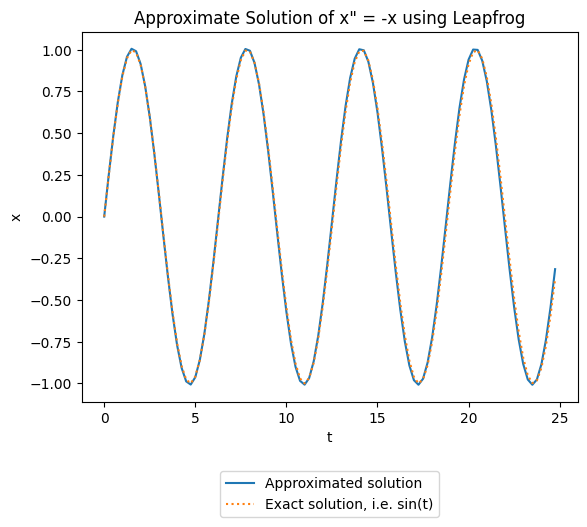

In [11]:
# NECESSARY IMPORTS

import numpy as np
import matplotlib.pyplot as plt

#================================================
# DEFINING f IN x" = f(x):

f = lambda x: -x

#================================================
# DEFINING THE INTEGRATOR'S PARAMETERS

n_steps = 100         # Number of approximation steps
Δt = 0.25             # Step size
x = np.empty(n_steps) # Position (i.e. the coordinates of the position)
v = np.empty(n_steps) # Velocity (i.e. the velocity vector)

#================================================
# INITIAL CONDITIONS

x[0] = 0
v[0] = 1
a_new = f(x[0])

#================================================
# PERFORMING LEAPFROG INTEGRATION

for i in range(1, n_steps): # Start with index 1 because index 0 contains the initial values
    a_old = a_new
    x[i] = x[i-1] + v[i-1]*Δt + 0.5*a_old*Δt**2
    a_new = f(x[i])
    v[i] = v[i-1] + 0.5*(a_old + a_new)*Δt

#================================================
# PLOTTING THE RESULTS

# NOTE: x is calculated for discrete points of time t as per time steps Δt

t = np.arange(0, len(x)*Δt, Δt)
plt.plot(t, x, label='Approximated solution')
plt.plot(t, np.sin(t), linestyle='dotted', label='Exact solution, i.e. sin(t)')
plt.title('Approximate Solution of x\" = -x using Leapfrog')
plt.xlabel('t')
plt.ylabel('x')
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.25))
plt.show()

### Leapfrog integration for HMC
Here, the leapfrom method shall be used to solve Hamiltonian equations.

---

To obtain the Hamiltonian equations, let us start with the Hamiltonian function (or simply the "Hamiltonian"):

$H(\theta, m) = K(\theta) + V(\theta) =$ _constant_

Here:

- We are dealing with a $k$ dimensional space (e.g. the sample space of a models' parameters)
- $\theta$: Position in the $k$ dimensional space; $\theta = (\theta_1, \theta_2 ... \theta_k)$, where $\theta_i$ is the $i$-th dimensional coordinate
- $m$: Momentum generalised for $k$ dimensions; $m = (m_1, m_2 ... m_k)$, where $m_i$ is the momentum along the $i$-th axis
- $K(m)$: System's total kinetic energy (independent of the position $\theta$)
- $V(\theta)$: System's total potential energy (independent of momentum $m$)

---

Using the Hamiltonian, we write Hamilton's equations of motion:

Equation 1:

$\frac{d \theta}{dt} = \frac{\delta H}{\delta m} = \frac{\delta K}{\delta m} + \frac{\delta V}{\delta m} = \frac{\delta K}{\delta m}$ (because $\frac{\delta V}{\delta m} = 0$)

i.e.

$\frac{d \theta}{dt} = \frac{\delta K}{\delta m}$

Equation 2:

$\frac{dm}{dt} = - \frac{\delta H}{\delta \theta} = - \frac{\delta K}{\delta \theta} - \frac{\delta V}{\delta \theta} = - \frac{\delta V}{\delta \theta}$ (because $\frac{\delta K}{\delta \theta} = 0$)

i.e.

$\frac{dm}{dt} = - \frac{\delta V}{\delta \theta}$

**NOTE**: _We are using a mechanistic analogy which can be accurately extended to posterior sampling._

---

We determine the change in the position $\theta$ according to the momentum $m$, and equation 2 shows that the momentum changes with respect to time by $- \frac{\delta V}{\delta \theta}$. Hence, starting with an initial momentum, the leapfrog integrator takes steps through time based on the chosen time step $\Delta t$, and for each step through time, it calculates the change in momentum since the last time step, thus obtaining the new momentum and the position for the next time step. In the context of HMC, each new position $\theta$ is a new sample from the posterior, and "time" means a sampling step.

---

> **Reference for the above**: ["MCMC METHOD 2: Hamiltonian Monte Carlo (HMC)" from "Markov chain Monte Carlo (MCMC)" from _Sampling Methods_ from **Bayesian Inference** from `conceptual-notes`](https://github.com/pranigopu/mastersProject/blob/main/conceptual-notes/bayesian-inference/sampling-methods.md#mcmc-method-2-hamiltonian-monte-carlo-hmc)

---

The implementation is below is modified from [_Hamiltonian Monte Carlo from scratch_ from **colindcarroll.com**](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/).

In [ ]:
def leapfrog(θ, m, δVδθ, T, Δt):
    '''
    Leapfrog integrator for Hamiltonian Monte Carlo
    ------------------------------------
    Parameters
    
    θ    : Initial position (i.e. coordinates of the initial position)
    m    : Momentum (i.e. momentum vector)
    δVδθ : Callable that returns the gradient of the "potential energy" V
    T    : Quantity indicating how long to integrate for
    Δt   : Quantity indicating how long each integration step should be

    NOTE: Why arrays for position and momentum? Because we are dealing with a k-dimensional space (k >= 1).

    ------------------------------------
    Returns

    θ, m : New position and momentum (both are vectors; θ is an array of coordinates, m is a vector)
    '''
    
    θ, m = np.copy(θ), np.copy(m)

    m -= Δt * δVδθ(θ)/2            # half step
    for _ in range(int(T/Δt) - 1):
        θ += Δt * m                # whole step
        m -= Δt * δVδθ(θ)          # whole step
    θ += Δt * m                    # whole step
    m -= Δt * δVδθ(θ)/2            # half step

    # Negate momentum at end of trajectory to make the proposal symmetric:
    '''
    REFERENCE FOR THE ABOVE COMMENT:
    MCMC using Hamiltonian dynamics by Radford M. Neal, https://arxiv.org/pdf/1206.1901
    '''
    return θ, -m

## HMC function

### Mathematical formulation
Let us first define the following:

- $P$, the measure of probability density or mass (depending on context)
- The target distribution $p = P(\theta|D)$ (the posterior distribution)
- $\theta$, the position, i.e. the sample taken from the posterior
- $m$, the momentum applied to the imaginary sampler point at position $\theta$
- $P(m)$, the model distributing potential momentum values

---

**KEY POINT**: The whole point of a sampling method is to estimate an unknown distribution. Hence, in practice, when we sample from the posterior, it is because we do not know the posterior. However, due to certain theoretical guarantees in the general MCMC approach (mainly the guarantee that the steady-state transition probabilities of the sampler's Markov chain simulate the posterior distribution; see: ["Markov chain Monte Carlo (MCMC)" from _Sampling Methods_ from **Bayesian Inference** from `conceptual-notes`](https://github.com/pranigopu/mastersProject/blob/main/conceptual-notes/bayesian-inference/sampling-methods.md#markov-chain-monte-carlo-mcmc)), we have that after a certain number of samples, we begin to draw samples as if from the posterior. Hence, when we say "sample from the posterior", we mean that in the way described by the general MCMC approach.

---

Hence, we have the following joint probability:

$P(\theta, m) = P(\theta|D) P(m)$

$\implies \log P(\theta, m) = \log (P(\theta|D) P(m)) = \log P(\theta|D) + \log P(m)$

$\implies - \log P(\theta, m) = - \log P(\theta|D) - \log P(m)$

---

Notice that the above equation is in the form of a Hamiltonian, where:

- $H(\theta, m) = - \log P(\theta, m)$
- $K(m) = - \log P(m)$ ("kinetic energy")
- $V(\theta) = - \log P(\theta|D)$ ("potential energy")

**NOTE**: _The logarithms of probabilities are always less than or equal to 0, since probabilities are always between 0 and 1. Hence, negative logarithms of probabilities are always greater than or equal to 0. Hence, the motion-based analogy is valid, which also means that Hamilton's equations of motion will work as intended, i.e. in the same way as they do for physical systems._

---

_What does this mean in practice?_

It means we can use one of Hamilton's equations, i.e. $\frac{d \theta}{dt} = \frac{\delta H}{\delta m}$, to travel along the contours of the negative log-probability of the posterior to propose the next sample (i.e. the next $\theta$) which is in a similarly high-probability-mass region of the posterior as the current sample (i.e. the current $\theta$). Note that we can make the proposal after a number of iterations for travelling along the above contour using the chosen momentum (chosen based on $P(m)$ ), and if we do so, we can get the proposed sample from a similarly high-probability-mass region of the posterior that is also far from the current sample. This number of iterations (or alternatively, the time for which we allow the algorithm to travel along the contour) can be picked at random to optimise the algorithm's performance in the long run (reference: [_Michael Betancourt: Scalable Bayesian Inference with Hamiltonian Monte Carlo_ from London Machine Learning Meetup, **YouTube**](https://www.youtube.com/watch?v=jUSZboSq1zg)).

---

_Hence, we see how HMC allows more efficient exploration of the high-probability-mass region of the posterior, compared to the approaches that explore by diffusing from a starting point over time (e.g. Metropolis-Hastings)._

### Algorithm and practical computation
- Initialise current sample as $\theta_0$
- Sample $m$ from $\text{Normal}(0, \sigma I)$
- Simulate $\theta_i$ and $m_i$ for some amount of time $T$
- Take $\theta_T$ as our new proposed sample
- Use the Metropolis acceptance criterion to accept or reject $\theta_T$

_Why we still need to use the Metropolis acceptance criterion?_ Intuitively, because we can think of HMC as a Metropolis-Hasting algorithm with a better proposal method. But a further numerical justification is that the accept-reject steps help correct for errors introduced by the numerical simulation of the Hamiltonian equations.

> **Reference**: ["11.9.3. Hamiltonian Monte Carlo" from "11.9. Inference Methods" from _11. Appendiceal Topics_ from **Bayesian Computation Notebook**](https://bayesiancomputationbook.com/markdown/chp_11.html#hamiltonian-monte-carlo)

---

The above algorithm is essentially two key steps (done for each iteration of HMC):

**Step 1: Obtain a new momentum**:

- A new momentum is randomly drawn from a Gaussian distribution
- The momentum is drawn independently of the current momentum and position

**NOTE**: _The momentum is always drawn anew from a Gaussian distribution every iteration._

 **Step 2: Probabilistically update both position and momentum**:
 
 - New momentum and position are obtained after a number of simulation steps
 - The new position is the new proposed sample
 - Update is "probabilistic" due to the Metropolis acceptance criterion

**NOTE**: _The new momentum and the new position are used to calculate the new Hamiltonian. This is important, because the difference between the previous Hamiltonian and the new Hamiltonian is needed to obtain the acceptance probability when checking the Metropolis acceptance criterion, as we shall see later._

> **Reference**: [_MCMC using Hamiltonian dynamics_ by Radford M. Neal](https://arxiv.org/pdf/1206.1901)

---

**NOTE**: "Simulate" <br>
$\implies$ Simulate the system defined by the Hamiltonian equations <br>
$\implies$ Travelling along the contours as per the momentum

#### Metropolis acceptance criterion for HMC
> **Reference**: [_MCMC using Hamiltonian dynamics_ by Radford M. Neal](https://arxiv.org/pdf/1206.1901)

As stated before, we need to use the Metropolis acceptance criterion for two reasons: (1) intuitively, we can think of HMC as a Metropolis-Hasting algorithm with a better proposal method, and (2) as a further numerical justification, the accept-reject steps help correct for errors introduced by the numerical simulation of the Hamiltonian equations.

_But how do we define the Metropolis criterion for HMC?_

Note that in the second essential step of the HMC algorithm, Hamiltonian dynamics are used to propose a new position (i.e. a new sample/state). Starting with the current position and momentum $(\theta, m)$, Hamiltonian dynamics are simulated for a number of steps (e.g. using the Leapfrog method); to be exact, we simulate the trajectory of the point representing the sampler for a number of steps, based on the momenta (as calculated throughout the steps) and the contours of the posterior (or more precisely, the negative log-probability of the posterior). The momentum at the end of this simulated trajectory is then negated (to see why, see the note below), giving a new position and momentum $(\theta^∗, m^*)$. The new, i.e. proposed position $\theta^*$ is accepted as the next state of the Markov chain with probability:

$\min [1, e^{H(\theta, m)−H(\theta^∗, m^∗)}]$, where:

- $H$ is the Hamiltonian, given by $H(\theta, m) = V(\theta) + K(m)$
- $V$ is analogous to the potential energy in classical mechanics
- $K$ is analogous to the kinetic energy in classical mechanics

If the proposed state (i.e. position) is not accepted, the next state is the same as the current state.

---

**Intuition for the above**:

We have the following cases:

1. $e^{H(\theta, m)−H(\theta^∗, m^∗)} \geq 1 \implies H(\theta^∗, m^∗) \geq H(\theta, m)$
2. $e^{H(\theta, m)−H(\theta^∗, m^∗)} \leq 1 \implies H(\theta^∗, m^∗) \leq H(\theta, m)$

$H(\theta^∗, m^∗) \geq H(\theta, m)$ means the proposed state is from an equal or higher-probability-mass region of the posterior, which means it should always be accepted, because we want to sample more from equal or higher-probability-mass regions. $H(\theta^∗, m^∗) < H(\theta, m)$ means the proposed state is from a lower-probability-mass region, which means it should be accepted only probabilistically, with the probability of accepting it being proportional to its closeness to the current state (in terms of probability density), because we want there to be a lower but non-zero chance of sampling from a sparser region region after sampling from a denser region, with the condition that the lower the density, the lower the chance.

---

**NOTE: Why negate the momentum variable after the simulation?**

The negation of the momentum at the end of the simulated trajectory makes the Metropolis proposal symmetrical, as needed for the acceptance probability above to be valid (**NOTE**: _I do not get this point_). However, this negation need not be done in practice, since $K(m) = K(−m)$, and since the momentum is always replaced (by randomly sampling it from a Gaussian) in the first step of the next iteration.

### Implementation
> **References**:
>
> - [_Hamiltonian Monte Carlo from scratch_ from **colindcarroll.com**](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)
> - [_MCMC using Hamiltonian dynamics_ by Radford M. Neal](https://arxiv.org/pdf/1206.1901)

In [128]:
from autograd import grad
import autograd.numpy as np
import scipy.stats as st

def hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, T=1, Δt=0.5):
    '''
    Run Hamiltonian Monte Carlo sampling.
    ------------------------------------
    Parameters
    
    n_samples         : Number of samples to return
    negative_log_prob : Callable that returns the negative log probability to sample from
    initial_position  : The initial position to start sampling from
    T                 : Quantity indicating how long to integrate; smaller is faster and more correlated
    Δt                : Quantity indicating how long each integration step should be; smaller is slower and more accurate.

    ------------------------------------
    Returns

    Array of length `n_samples`
    '''
    
    # Using autograd to obtain the required differential:
    δVδθ = grad(negative_log_prob)

    # Collect all our samples in a list:
    samples = [initial_position]

    # Keep a single object for momentum resampling:
    momentum = st.norm(0, 1) # Keeping σ (sigma) at 1
    size = n_samples*initial_position.shape[0]
    momentum_samples = momentum.rvs(size=size)
    '''
    EXPLAINING THE ABOVE THREE LINES:
    
    Let's say the `initial_position` is a 10-dimensional vector and `n_samples` is 100.
    Then, we want 100 x 10 momentum draws (note that this is just an example).
    To achieve such functionality, we do one call to `momentum.rvs` and iterate over rows.
    '''
    
    for m in momentum_samples:
        # Integrate over our path to get a new position and momentum:
        θ_T, m_T = leapfrog(samples[-1], m, δVδθ, T=T, Δt=Δt)
        # NOTE: `θ_T` is the proposed position, i.e. proposed sample

        # Check Metropolis acceptance criterion:
        H_old = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(m))
        H_new = negative_log_prob(θ_T) - np.sum(momentum.logpdf(m_T))
        # NOTE: H denotes "Hamiltonian"
        if np.log(np.random.rand()) < H_old - H_new:
            '''
            EXPLAINING THE ABOVE CONDITION: See the implementation note below.
            '''
            samples.append(θ_T)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

**IMPLEMENTATION NOTE: Explaining** `if np.log(np.random.rand()) < H_old - H_new`:

Note that the Metropolis acceptance probability for HMC is:

$min[1, e^{H(\theta, m) − H(\theta^∗, m^∗)}]$, where:

- $\theta$: Current position
- $m$: Current momentum
- $\theta^*$: Proposed position (after leapfrog integration steps)
- $m^*$: New momentum (after leapfrog integration steps)
- $H(\theta, m)$: `H_old`
- $H(\theta^*, m^*)$ = `H_new`

But note that:

$\min[1, e^{H(\theta, m) − H(\theta^*, m^*)}]$

$= \min[\log(1), \log(e^{H(\theta, m) − H(\theta^*, m^*)})]$

$= \min[0, H(\theta, m) − H(\theta^*, m^*)]$

Hence, we see that the condition `if np.log(np.random.rand()) < H_old - H_new` is equivalent to the condition `if np.random.rand() < np.exp(H_old - H_new)`, and both conditions accurately model the acceptance probability $\min[1, e^{H(\theta, m) − H(\theta^∗, m^∗)}]$.

In [34]:
!pip install minimc

ERROR: Could not find a version that satisfies the requirement minimc (from versions: none)
ERROR: No matching distribution found for minimc


In [33]:
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt

# Using code from https://github.com/ColCarroll/minimc/tree/e6948430447ec94240568540d42405a51d3aca26
from minimc.minimc_slow import leapfrog, hamiltonian_monte_carlo
from minimc import neg_log_mvnormal
plt.style.use('tufte')
def neg_log_p_to_img(neg_log_p, extent=None, num=100):
    if extent is None:
        extent = (-3, 3, -3, 3)
    X, Y = np.meshgrid(np.linspace(*extent[:2], num), np.linspace(*extent[2:], num))
    Z = np.array([np.exp(-neg_log_p(j)) for j in np.array((X.ravel(), Y.ravel())).T]).reshape(X.shape)
    return Z, extent
np.random.seed(1)

neg_log_p = neg_log_mvnormal(np.zeros(2), np.eye(2))
dVdq = grad(neg_log_p)


positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    _, _, q, p = leapfrog(q, p, dVdq, 2 * np.pi, 0.01)
    positions.append(q)
    momentums.append(p)
fig, axes = plt.subplots(ncols=len(positions), figsize=(7 * len(positions), 7))


steps = slice(None, None, 40)

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 3, -3, 3), num=200)

for idx, (ax, q, p) in enumerate(zip(axes.ravel(), positions, momentums)):
    ax.imshow(Z, alpha=0.9, extent=extent, cmap='afmhot_r', origin='top')

    ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], headwidth=6, scale=60, headlength=7, alpha=0.8, color='C0')
    ax.plot(q[:, 0], q[:, 1], '-', lw=3, color='C0')
plt.savefig('normal_leapfrog.png')

ModuleNotFoundError: No module named 'minimc'